In [ ]:
# ✅ Install OpenAI and image tools
!pip install --upgrade openai opencv-python-headless numpy matplotlib scikit-image

# ✅ Import packages
from openai import OpenAI
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from google.colab import files
import base64
import os


In [ ]:
# ✅ Enter your API key here
OPENAI_API_KEY = "hello-hackaton"
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

client = OpenAI()


📤 Please upload your reference building image:


Saving Cube.jpg to Cube.jpg


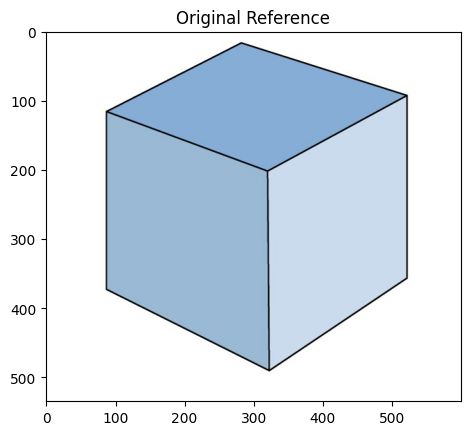

In [ ]:
print("📤 Please upload your reference building image:")
uploaded = files.upload()

# Assume single image:
filename = list(uploaded.keys())[0]

# Read + show
img = cv2.imread(filename)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Reference")
plt.show()


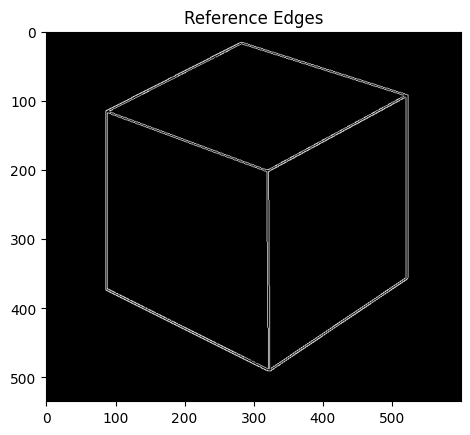

True

In [ ]:
edges = cv2.Canny(gray, 50, 150)
plt.imshow(edges, cmap='gray')
plt.title("Reference Edges")
plt.show()

cv2.imwrite("reference_edges.png", edges)


In [ ]:
# Encode for GPT Vision
with open("reference_edges.png", "rb") as f:
    b64_img = base64.b64encode(f.read()).decode()

response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "You are an expert shape describer."},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Describe this building's basic massing: e.g. 'one tall box with a small cylinder on top'. Keep it simple."},
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{b64_img}"}}
            ]
        }
    ]
)

shape_description = response.choices[0].message.content.strip()
print("✅ Shape description:", shape_description)


✅ Shape description: A single cube.


In [ ]:
response2 = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": (
            "You are a p5.js sketch generator. "
            "Output ONLY valid raw JavaScript, no markdown. "
            "Load dat.GUI dynamically, use global params, use orbitControl() in draw(). "
            "Do NOT use noLoop(). "
            "Do NOT add automatic rotation."
        )},
        {"role": "user", "content": f"Write a p5.js sketch for this shape: {shape_description}. "
                                    "Use createCanvas(400,400,WEBGL). Include GUI for sizes, colors, stroke weight."}
    ]
)

p5_code = response2.choices[0].message.content.strip()
p5_code = p5_code.replace("```javascript", "").replace("```", "")
print(p5_code)

# Save to file
with open("sketch.js", "w") as f:
    f.write(p5_code)



let params = {
  size: 100,
  strokeWeight: 2,
  fillColor: '#ff0000',
  strokeColor: '#000000'
};

let gui;

function setup() {
  createCanvas(400, 400, WEBGL);
  
  // Dynamically load dat.GUI
  const script = document.createElement('script');
  script.src = 'https://cdnjs.cloudflare.com/ajax/libs/dat-gui/0.7.9/dat.gui.min.js';
  script.onload = () => {
    gui = new dat.GUI();
    gui.add(params, 'size', 10, 200).name('Cube Size');
    gui.addColor(params, 'fillColor').name('Fill Color');
    gui.addColor(params, 'strokeColor').name('Stroke Color');
    gui.add(params, 'strokeWeight', 0, 10).name('Stroke Weight');
  };
  document.head.appendChild(script);
}

function draw() {
  background(240);
  orbitControl();

  strokeWeight(params.strokeWeight);
  stroke(params.strokeColor);
  fill(params.fillColor);

  box(params.size);
}



📤 Please upload the screenshot you saved from p5.js:


Saving Screenshot 2025-06-14 211126.png to Screenshot 2025-06-14 211126.png


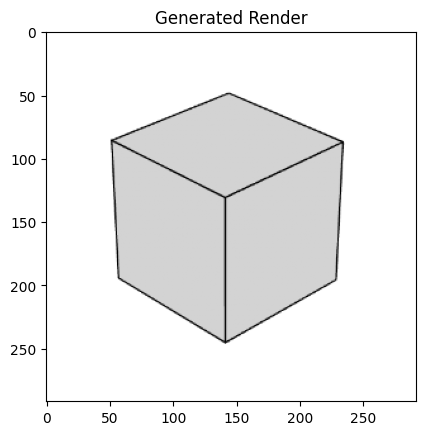

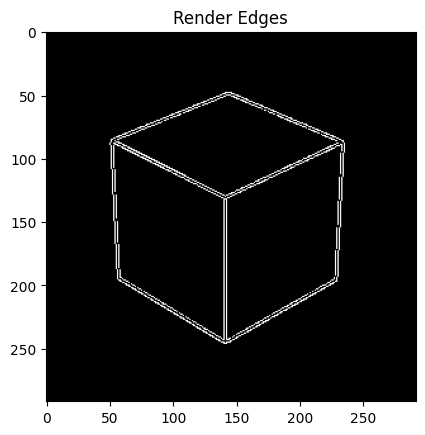

True

In [ ]:
print("📤 Please upload the screenshot you saved from p5.js:")
uploaded_render = files.upload()

render_name = list(uploaded_render.keys())[0]
render = cv2.imread(render_name, cv2.IMREAD_GRAYSCALE)

plt.imshow(render, cmap='gray')
plt.title("Generated Render")
plt.show()

# Edge detect
render_edges = cv2.Canny(render, 50, 150)
plt.imshow(render_edges, cmap='gray')
plt.title("Render Edges")
plt.show()

cv2.imwrite("render_edges.png", render_edges)


✅ SSIM similarity score: 0.7606


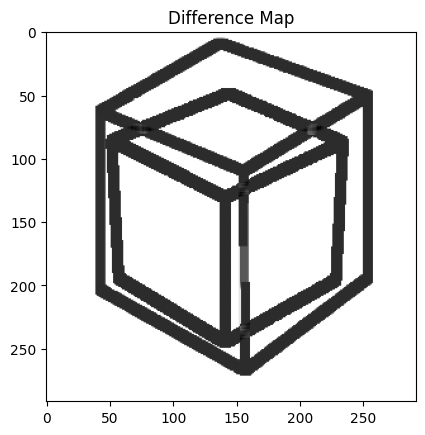

In [ ]:
# Resize to same size
h = min(edges.shape[0], render_edges.shape[0])
w = min(edges.shape[1], render_edges.shape[1])
ref_resized = cv2.resize(edges, (w, h))
render_resized = cv2.resize(render_edges, (w, h))

# SSIM
score, diff = ssim(ref_resized, render_resized, full=True)
print(f"✅ SSIM similarity score: {score:.4f}")

plt.imshow(diff, cmap='gray')
plt.title("Difference Map")
plt.show()


In [ ]:
def encode_img(path):
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode()

ref_b64 = encode_img("reference_edges.png")
render_b64 = encode_img("render_edges.png")

response3 = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "You are a strict architectural critic. Compare two edge images and point out exact mismatches in short bullet points."},
        {"role": "user", "content": [
            {"type": "text", "text": "Compare these two: where is the parametric massing wrong or missing?"},
            {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{ref_b64}"}},
            {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{render_b64}"}}
        ]}
    ]
)
critique = response3.choices[0].message.content.strip()
print("🗂️ Discriminator feedback:\n", critique)


🗂️ Discriminator feedback:
 - **Size Discrepancy**: The first image shows a larger cube compared to the second image.
- **Edge Detail**: The second image lacks the visible thickness or double-line edge detail present in the first image.
- **Line Detail**: The second image has fewer visible line details than the first image, which shows more pronounced lines.
- **Perspective**: The viewing angle seems slightly different, with the second image appearing more tilted.


In [ ]:
response4 = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": (
            "You are a p5.js code improver. Always output only raw JS. "
            "Use the same param structure, improve the code to fix the feedback."
        )},
        {"role": "user", "content": f"""
Original goal: {shape_description}

Previous p5.js:
{p5_code}

Discriminator feedback:
{critique}

Fix the issues and output the new p5.js code only.
"""}
    ]
)

new_p5_code = response4.choices[0].message.content.strip()
new_p5_code = new_p5_code.replace("```javascript", "").replace("```", "")
print(new_p5_code)

# Save new version
with open("sketch_improved.js", "w") as f:
    f.write(new_p5_code)



let params = {
  size: 100,
  strokeWeight: 2,
  fillColor: '#ff0000',
  strokeColor: '#000000'
};

let gui;

function setup() {
  createCanvas(400, 400, WEBGL);
  
  // Dynamically load dat.GUI
  const script = document.createElement('script');
  script.src = 'https://cdnjs.cloudflare.com/ajax/libs/dat-gui/0.7.9/dat.gui.min.js';
  script.onload = () => {
    gui = new dat.GUI();
    gui.add(params, 'size', 10, 200).name('Cube Size');
    gui.addColor(params, 'fillColor').name('Fill Color');
    gui.addColor(params, 'strokeColor').name('Stroke Color');
    gui.add(params, 'strokeWeight', 0, 10).name('Stroke Weight');
  };
  document.head.appendChild(script);
}

function draw() {
  background(240);
  // Stabilize perspective
  rotateX(PI / 6);
  rotateY(PI / 6);
  // Improve distribution of control for rotation
  orbitControl(1, 1, 0.1);

  // Set stroke properties
  strokeWeight(params.strokeWeight);
  stroke(params.strokeColor);
  fill(params.fillColor);

  push();
  translate(0, 0, 